In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.preprocessing import MinMaxScaler

from CustomModels import MyModel_REGR
from CustomModels import extra_func

import seaborn as sns
sns.set(style='ticks', context='talk')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Recurental neural network

Main goal for this chapter is to develop a machine learning model that will predict future rank of the stock, given its ranking through time.

Model based on LSTM NN (ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/), as of our ranking series is a time series.
I will use Tensorflow/Keras implementation of LSTM, but GPU-version of it: CuDNNLSTM. GPU speed up is significant as we will run through huge amounts of data.
Model wrapped in its own class, object-oriented-style ( @ `./CustomModels/MyModel_REGR.py`). Class had some flexible options on how to construct LSTM model, such as : 
1. Test/Validation set percentage part
2. Mode for CPU/GPU implementation of LSTM cells
3. Usage of regularization (Elastic, l1 and l2)
4. Usage of Dropout layer
5. Number of layers
6. Number of neurons (in first layer, rest will decay as n//2)
7. Epochs, window size, batch size, etc (LSTM parameters)

All test are logged in Tensorboard format, stored @ `./data/logs/`

P.S. As a research i made some list-wise'ish model with divergence as loss function. Also there are categorization models , taking ranks as a category, one-hot'ting them later, not so much on perfomance either.

At first, lets check our hardware, for running tf on GPU we need NVIDIA-CUDA graphics card, all drivers preinstalled. Im running Linux Manjaro with bumblebee switch, notebook should be started as <br>`[user]$ optirun jupyter-notebook`

In [2]:
# import tensorflow as tf
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

Function for going through stock ticker per ticker, creating and evaluating LSTM model:

In [16]:
def get_predictions(df,ticker,shift,features,window,mode):
    X = df.loc[:,(slice(None),ticker,'volume')].diff().dropna()
    X = pd.DataFrame(MinMaxScaler().fit_transform(X),index=X.index,columns=X.columns)
    y = X.shift(-shift).dropna()
    X = X[:-shift]
    stock_model = MyModel_REGR.StockPred(X.values,y.values,
                                    test_ratio=.2,
                                    val_ratio=.1,
                        mode=mode,
                        ticker=ticker,
                        use_reg = True,
                        neurons=10,
                        layers=1,
                        features=features,
                        batch_size=64,
                        epochs=2,
                        window=window)
    
    # Creating model in class
    stock_model.gen_model(use_dropout=False,use_norm=True)
    #This can show model structure
    #stock_model.model.summary()
    acc = stock_model.compile(verbose=1)
    
    # For now prediction is going on all of data avaluable: train-validation-test, which as BAD, but it doing ok on testing sets
    model_pred = stock_model.model.predict_generator(stock_model.total_gen).reshape((1,-1))[0]
    #model_pred = model_pred[shift:]
    real = y#.iloc[window:-shift]
    predictions = pd.Series(model_pred,index=X.iloc[window:].index)

    return predictions,real

In [3]:
# with open('./data/market.pkl','rb') as f:
#     df = pickle.load(f)

with open('./data/market_data_pd.pkl','rb') as f:
    df = pickle.load(f).asfreq('C').dropna()

- SHIFT - time delta into future, predicting this number
- FEATURES - number of columns in data for model, set for 1 for now
- WINDOW - time period for LSTM cells to analyze
- MODE - CPU/GPU

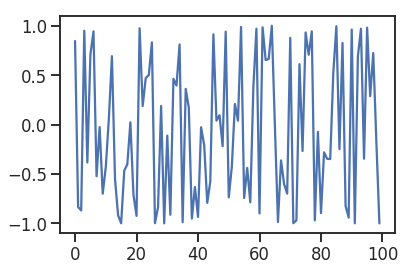

In [50]:
t = np.arange(40000)*(np.sin(np.arange(40000)))
st = np.sin(t/10)# + np.arange(40000)/1000
plt.plot(st[1000:1100])
df = pd.DataFrame(st,columns=pd.MultiIndex.from_tuples([('SECT','TICK','rank')]))

In [6]:
DAY = 26 # 15 minutes data in df, 26 per day
SHIFT = DAY * 5
FEATURES = 1 #len(X.columns)
WINDOW = DAY * 5
MODE='cpu'
#df = df.loc[:,(slice(None),slice(None),'rank')]#.diff().rolling(SHIFT).sum()
#tdfs = {}

# for s in df.columns.get_level_values(0).drop_duplicates():
#     t_min = df[s].min(axis=1).min()#.dropna()
#     t_max = df[s].max(axis=1).max()#.dropna()
#     t_d = t_max-t_min
    
#     df[s]-=t_min
#     df[s]/=t_d
#     #std = df[s].subtract(t_min.values,axis=0).div(t_d.values,axis=0)
    
#     df[s] = df[s].multiply(1- (-1)).add(-1)

#tdfs = pd.concat(tdfs,axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52962 entries, 2010-01-04 09:45:00 to 2018-02-05 16:00:00
Columns: 1318 entries, (Basic Materials, AA, close) to (Utilities, XEL, volume)
dtypes: float32(1318)
memory usage: 266.7 MB


###  Time to do some damage! iterating through stocks, building models, dumping them, making predictions, logging everything. 4hrs + on Nvidia GTX 950m

In [7]:
# blacklist = ttdf.columns.values

In [8]:
# tickers = df.columns.get_level_values(1).drop_duplicates().values
# dfs = {}
# with open('./data/market_pred.pkl','wb') as f:
#     for i,ticker in enumerate(tqdm_notebook(tickers,desc=f'Running on {MODE}: ')):
#         #blacklist is for interrupted cycles, not to run again on restored data from dump
#         if ticker not in blacklist:
#             s = get_predictions(df,ticker,SHIFT,FEATURES,WINDOW,MODE)
#             dfs[ticker] = s.astype('float32')
#             if i%6==0:
#                 pickle.dump(dfs,f)
    

In [9]:
# with open('./data/market_pred_as_df.pkl','wb') as f:
#     pickle.dump(tdf,f)

In [17]:
s1,s2 = get_predictions(df,'AMZN',SHIFT,FEATURES,WINDOW,'cpu')

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Epoch 1/2
592/592 [==============================] - 38s 64ms/step - loss: 0.0973 - mean_squared_error: 0.0969 - val_loss: 4.8036e-04 - val_mean_squared_error: 3.8413e-04
Epoch 2/2
592/592 [==============================] - 40s 68ms/step - loss: 6.8357e-04 - mean_squared_error: 6.3126e-04 - val_loss: 0.0413 - val_mean_squared_error: 0.0412
Model 09.12-14:48_AMZN-2E1L1F130W64B10N compiled! Calculating accuracy...


In [18]:
s1.shape,s2.iloc[WINDOW:].shape

((52604,), (52604, 1))

In [26]:
s2[:50].values.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

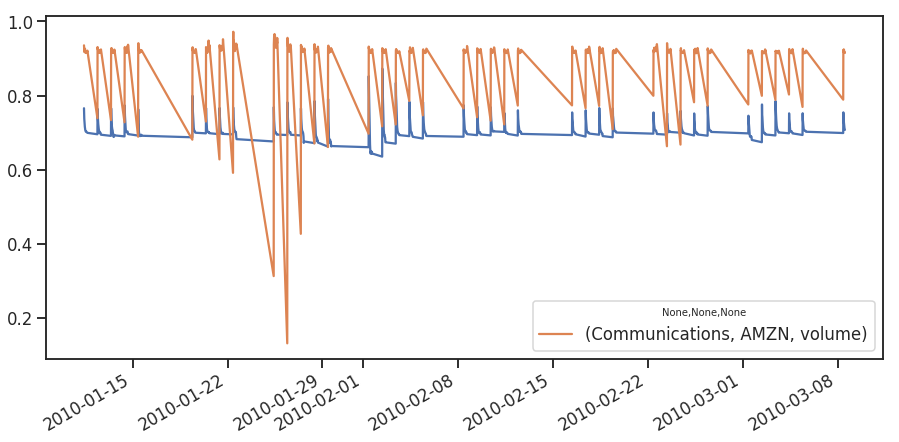

In [21]:
f,ax = plt.subplots(1,1,figsize=(15,7))

s1[:1000].plot(ax=ax)
s2.iloc[WINDOW:][:1000].plot(ax=ax)

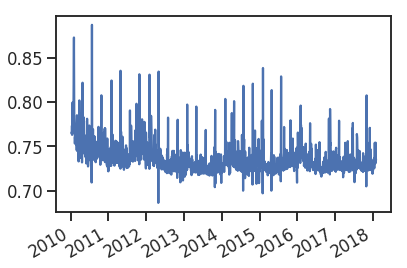

In [35]:
s1.asfreq('C').dropna().plot()

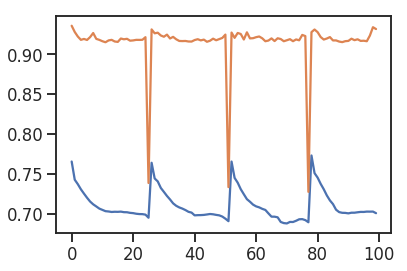

In [29]:
t1=s1[:100].values
t2=s2.iloc[WINDOW:][:100].values
plt.plot(t1)
plt.plot(t2)

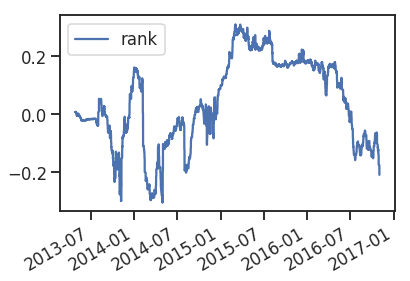

In [14]:
df.Energy.ANDV.plot()

In [20]:
#model_pred = stock_model.model.predict_generator(stock_model.total_gen).reshape((1,-1))[0]
#model_pred = model_pred[SHIFT:]
real = s2.iloc[WINDOW:]#y.iloc[WINDOW:-SHIFT]
predictions = s1#pd.Series(model_pred,index=real.index)
pr = predictions.values.reshape((1,-1))[0]
re = real.values.reshape((1,-1))[0]
np.corrcoef(pr,re)

array([[1.        , 0.81313965],
       [0.81313965, 1.        ]])

In [16]:
# (~(t2.values.reshape((1,-1))[0] == t1)).sum()

In [17]:
#extra_func.series_visualise(X.close.diff().dropna(),lags=50)

In [18]:
# t = X.close['2010':'2018'].asfreq('D').dropna()
# t.plot(label='Raw',figsize=(15,8))
# t.rolling(28).mean().plot(label='28D MA')
# t.expanding().mean().plot(label='Expanding Average')
# t.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

# plt.legend(bbox_to_anchor=(1.25, .5))
# plt.tight_layout()
# plt.ylabel("Close ($)")

# sns.despine()

In [19]:
s = df.Technology.AAPL.close.dropna()
me = df.dropna().mean(axis=1)


AttributeError: 'DataFrame' object has no attribute 'close'

In [ ]:
((s-me)/me)['2012'].plot()

In [ ]:
t = pd.DataFrame(np.random.normal(0,10,24).reshape((-1,3)))

In [ ]:
t